In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from math import sqrt
import seaborn as sns
import pickle
from sklearn.metrics import r2_score
import shap

In [ ]:
df = pd.read_excel("DatosConsolidados.xlsx", index_col = 'Fecha').reset_index()
df["consumoshift"] = df['Consumo'].shift(-1)
df =  df.drop(columns = ['   '])
df["Codigo"] = df["Codigo"].map(lambda x: x.strip())
df= df.dropna()
df = df.iloc[2: , :]
df.columns

Index(['Fecha', 'Codigo', 'Tipo', 'AA', 'MM', 'Consumo', 'Altas',
       'DsvStdConsumoAA', 'PromedioConsumoAnual', 'DsvStdConsumo3M',
       'PromedioConsumo3M', 'consumoshift'],
      dtype='object')

In [ ]:
ohe = OneHotEncoder(sparse= False, categories='auto')
X, y = df.iloc[:,1:-1], df.iloc[:,-1]
columnTransformer = ColumnTransformer([('ohe',ohe,["Codigo","Tipo"])], remainder='passthrough')
X = columnTransformer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)
model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
model.score(X_test, y_test)

0.7762362944345589

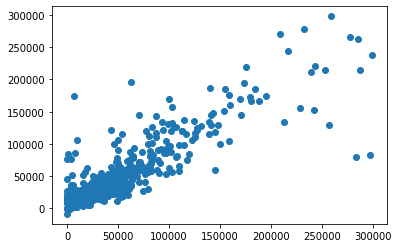

In [ ]:
plt.scatter(y_test, y_pred)

In [ ]:
#grid_random = {'max_depth': [2, 4, 6], 'gamma': np.arange(0, 10, 1), 
               #'n_estimators': [250, 700, 500], 'learning_rate': [0.02, 0.005, 0.01], 'subsample': np.arange(0.5, 1.0, 0.01)}


grid_random = {'max_depth': [2], 'gamma': [3], 
               'n_estimators': [700], 'learning_rate': [0.005], 'subsample': [0.55]}

model = XGBRegressor(objective = 'reg:squarederror')
model_random = RandomizedSearchCV(estimator = model, param_distributions = grid_random, n_iter = 50, cv = 5, verbose = 2, random_state = 42, n_jobs = -1)
model_random.fit(X_train, y_train)
print("Best score: %f with %s" % (model_random.best_score_, model_random.best_params_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.


Best score: 0.807311 with {'subsample': 0.55, 'n_estimators': 700, 'max_depth': 2, 'learning_rate': 0.005, 'gamma': 3}


In [ ]:
bestmodel = XGBRegressor(**model_random.best_params_)
bestmodel.fit(X_train, y_train)
y_pred = bestmodel.predict(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


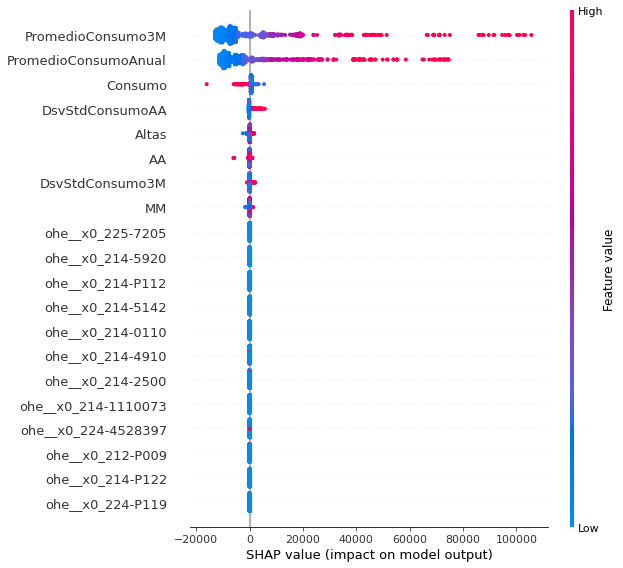

In [ ]:
explainer = shap.TreeExplainer(bestmodel)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test,feature_names=columnTransformer.get_feature_names())

0.7860464621039585


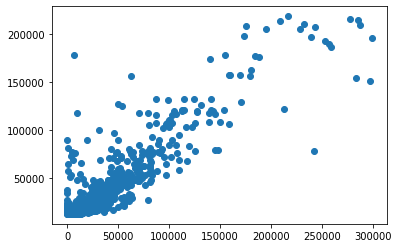

In [ ]:
print(r2_score(y_test, y_pred))
#for excel
plt1 = plt.scatter(y_test, y_pred)
#for visualization
plt.scatter(y_test, y_pred)


In [ ]:
with open('mysaved_md_pickle', 'wb') as file:
    pickle.dump(bestmodel,file)
#now we weill load the saved model
with open('mysaved_md_pickle', 'rb') as file:
    loaded_model = pickle.load(file)

In [ ]:
df = pd.read_excel("DatosConsolidados.xlsx", index_col = 'Fecha').reset_index()
df2 = pd.read_excel("MMP.xlsx",index_col = 'FECHA').reset_index()
df2["MMP"] = df2['MMP'].shift(1)
df2.rename(columns={"FLD_MATCODIGO":"Codigo","FECHA":"Fecha"}, inplace = True)
df2 = df2[["Fecha","Codigo","MMP"]]
df_merged = df.merge(df2, on = ['Fecha','Codigo'],how = 'left')
df_merged.dropna()


,Fecha,Codigo,Tipo,AA,MM,Consumo,Altas,DsvStdConsumoAA,PromedioConsumoAnual,DsvStdConsumo3M,PromedioConsumo3M,,MMP
70,01/02/2012 0:00:00.000,212-P008,FARMACO,2012,2,18000,1627,17249.505922,18500,10392.304845,12000,,27898.67
71,01/03/2012 0:00:00.000,212-P008,FARMACO,2012,3,18000,1877,17249.505922,18500,10392.304845,12000,,36086.67
72,01/04/2012 0:00:00.000,212-P008,FARMACO,2012,4,36000,1858,17249.505922,18500,27495.454170,30000,,35553.33
74,01/06/2012 0:00:00.000,212-P008,FARMACO,2012,6,54000,1801,17249.505922,18500,27495.454170,30000,,37476.67
77,01/09/2012 0:00:00.000,212-P008,FARMACO,2012,9,36000,1545,17249.505922,18500,20784.609691,12000,,39226.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,01/11/2020 0:00:00.000,241-1552,INSUMO,2020,11,81600,2549,53262.215842,79000,39153.543901,77600,,205493.33
3596,01/12/2020 0:00:00.000,241-1552,INSUMO,2020,12,114600,2540,53262.215842,79000,39153.543901,77600,,223396.67
3597,01/01/2021 0:00:00.000,241-1552,INSUMO,2021,1,52000,2525,37470.165910,41733,37470.165910,41733,,218500.00
3598,01/02/2021 0:00:00.000,241-1552,INSUMO,2021,2,200,2248,37470.165910,41733,37470.165910,41733,,235343.33


In [ ]:
#loaded_model.predict(X_test[0])
#bestmodel.predict(pd.DataFrame(X_test[0]))

In [ ]:
loaded_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.005, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=700, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.55,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
test = df_merged.sample(150)
test = test.dropna()
testMMP = test["MMP"]
testconsumo = test["Consumo"]
test = test.drop(columns = ['Consumo', "MMP"],)
test2 = test.iloc[:,1:-1]

In [ ]:
test

,Fecha,Codigo,Tipo,AA,MM,Altas,DsvStdConsumoAA,PromedioConsumoAnual,DsvStdConsumo3M,PromedioConsumo3M,
321,01/01/2018 0:00:00.000,212-P009,FARMACO,2018,1,1589,9946.961619,43175,9174.057626,35033,
1246,01/02/2020 0:00:00.000,214-5142,FARMACO,2020,2,2783,44740.054422,72288,34460.425612,42386,
3357,01/01/2016 0:00:00.000,225-7254,INSUMO,2016,1,1620,9733.481539,19345,1517.673658,8633,
2085,01/01/2015 0:00:00.000,224-4530397,INSUMO,2015,1,1604,4884.343977,33259,7110.770493,31411,
509,01/09/2018 0:00:00.000,214-0110,FARMACO,2018,9,2501,11232.811785,25916,8504.900548,32666,
...,...,...,...,...,...,...,...,...,...,...,...
1876,01/08/2012 0:00:00.000,224-4528397,INSUMO,2012,8,1770,6017.294119,22501,6257.020058,25790,
3166,01/02/2015 0:00:00.000,225-7210,INSUMO,2015,2,1495,27013.829231,110016,10055.015332,97033,
1791,01/07/2020 0:00:00.000,214-P122,FARMACO,2020,7,2309,72315.271345,89298,47620.150147,62870,
155,01/03/2019 0:00:00.000,212-P008,FARMACO,2019,3,3006,6647.581925,24180,7943.280179,26020,


In [ ]:
columnTransformer = ColumnTransformer([('ohe',ohe,["Codigo","Tipo"])], remainder='passthrough')
subset = columnTransformer.fit_transform(test2)
modepredict=loaded_model.predict(X)

In [ ]:
test['Predicion'] = pd.DataFrame(modepredict)
test["MMP"]= testMMP
test["Consumo"] = testconsumo


In [ ]:
test = test[['Predicion','Consumo','MMP']]
test.dropna(inplace = True)
test


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Predicion,Consumo,MMP
321,36396.820312,35800,169613.33
1246,76764.179688,81180,59476.67
3357,17115.595703,10000,31220.00
2085,35968.097656,35164,16603.33
509,25981.656250,41000,17600.00
...,...,...,...
1876,20333.445312,32380,26500.00
3166,131672.125000,86800,62566.07
1791,17059.525391,87200,60814.17
155,24245.158203,35010,30500.00


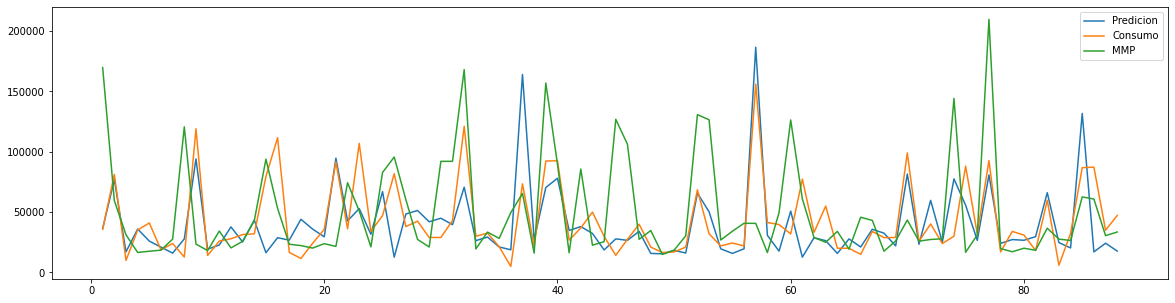

In [ ]:
#plt.plot(test['Predicion'])
#plt.plot(test["MMP"])
#plt.plot(test["Consumo"])
#plt.show()

x = np.linspace(1, 88, 88)
fig = plt.figure(figsize=(20,5))
ax = plt.axes()
ax.plot(x, test['Predicion'],label = 'Predicion')
ax.plot(x, test['Consumo'], label = 'Consumo')
ax.plot(x, test['MMP'], label = 'MMP')
plt.legend()


<AxesSubplot:>

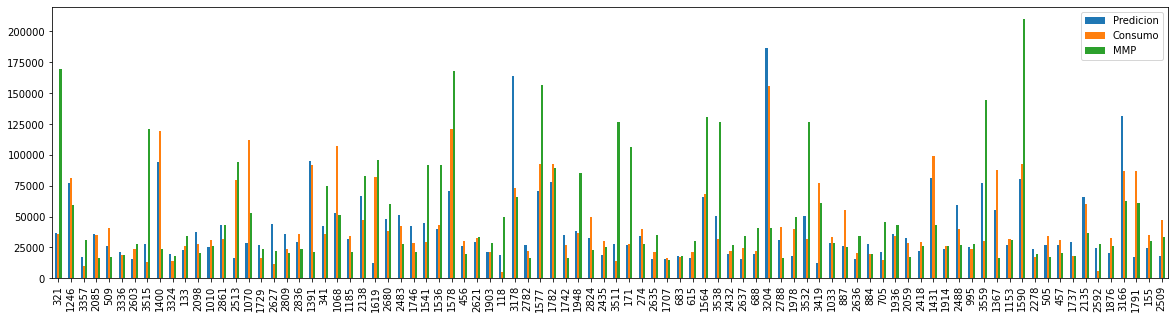

In [ ]:
test.plot(kind="bar",figsize=(20,5))

In [ ]:
r2_score(test.Consumo,test.MMP)

-1.0980922317134967

In [ ]:
r2_score(test.Consumo,test.Predicion)

0.32166958715031735

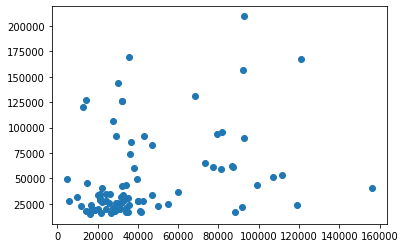

In [ ]:
plt.scatter(test.Consumo,test.MMP)

In [1]:
plt.scatter(test.Consumo,test.Predicion)

NameError: ignored

In [ ]:
import xlsxwriter
import numpy as np
import matplotlib.pyplot as plt
import io

In [ ]:
#Take the test chart to excel adding the logistics column
test.insert(3,'Pedido_Departamento_Suministros',str)

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('PrediccionesXgboost.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
test.to_excel(writer, sheet_name='Sheet1')
test2.to_excel(writer, sheet_name='Sheet2',index=False)



In [ ]:
#Take the images to excel
x=np.linspace(-10,10,100)
y=x**2

fig,ax=plt.subplots()
ax.plot(x,y)

wks1=writer.add_worksheet('Sheet2')
wks1.write(0,0,'plt1')

imgdata=io.BytesIO()
plt1.savefig(imgdata, format='png')
wks1.insert_image(2,2, '', {'image_data': imgdata})

In [ ]:
# Close the Pandas Excel writer and output the Excel file.
writer.save()

#This is for it to work in colab, you must add the address you want the file to be saved as
!cp CostosGananciasPython.xlsx "/content/drive/MyDrive/Avante_Mercado_Libre/Programas/Costos_y_Ganancias_Listos"
